# Stationary behaviour of EIP 1559 agent-based model

###### July 2020, [@barnabemonnot](https://twitter.com/barnabemonnot)
###### [Robust Incentives Group](https://github.com/ethereum/rig), Ethereum Foundation

---

We introduce here the building blocks of agent-based simulations of EIP1559. This follows an [earlier notebook](https://nbviewer.jupyter.org/github/ethereum/rig/blob/master/eip1559/eip1559.ipynb) that merely looked at the dynamics of the EIP 1559 mechanism. In the present notebook, agents decide on transactions based on the current basefee and form their transactions based on internal evaluations of their values and costs.

[Huberman et al., 2019](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3025604) introduced such a model and framework for the Bitcoin payment system. We adapt it here to study the dynamics of the basefee.

All the code is available in [this repo](https://github.com/barnabemonnot/abm1559), with some preliminary documentation [here](https://barnabemonnot.com/abm1559/build/html/). You can also download the [`abm1559` package from PyPi](https://pypi.org/project/abm1559/) and reproduce all the analysis here yourself!

## The broad lines

We have several entities. _Users_ come in randomly (following a Poisson process) and create and send transactions. The transactions are received by a _transaction pool_, from which the $x$ best _valid_ transactions are included in a _block_ created at fixed intervals. $x$ depends on how many valid transactions exist in the pool (e.g., how many post a gasprice exceeding the prevailing basefee in 1559 paradigm) and the block gas limit. Once transactions are included in the block, and the block is included in the _chain_, transactions are removed from the transaction pool.

How do users set their parameters? Users have their own internal ways of evaluating their _costs_. Users obtain a certain _value_ from having their transaction included, which we call $v$. $v$ is different for every user. This value is fixed but their overall _payoff_ decreases the longer they wait to be included. Some users have higher time preferences than others, and their payoff decreases faster than others the longer they wait. Put together, we have the following:

$$ \texttt{payoff} = \texttt{value} - \texttt{cost from waiting} - \texttt{transaction fee} $$

Users expect to wait for a certain amount of time. In this essay, we set this to a fixed value -- somewhat arbitrarily we choose 5. This can be readily understood in the following way. Users estimate what their payoff will be from getting included 5 blocks from now, assuming basefee remains constant. If this payoff is negative, they decide not to send the transaction to the pool (in queuing terminology, they _balk_). We'll play with this assumption later.

The scenario is set up this way to study _stationarity_: assuming some demand comes in from a fixed distribution at regular intervals, we must expect basefee to reach some stationary value and stay there. It is then reasonable for users, at this stationary point, to consider that 5 blocks from now basefee will still be at the same level. In the nonstationary case, when for instance a systemic change in the demand happens (e.g., the rate of Poisson arrivals increases), a user may want to hedge their bets by estimating their future payoffs in a different way, taking into account that basefee might increase instead. This strategy would probably be a good idea during the _transition_ phase, when basefee shifts from one stationary point to a new one.

We make the assumption here that users choose their 1559 parameters based on their value alone. We set the transaction `max_fee` parameter to the value of the user and set the `gas_premium` parameter to a residual value -- 1 Gwei per unit of gas.

There is no loss of generality in assuming all users send the same transaction in (e.g., a simple transfer) and so all transactions have the same `gas_used` value (21,000). In 1559 paradigm, with a 20M gas limit per block, this allows at most 952 transactions to be included, although the mechanism will target half of that, around 475 here. The protocol adjusts the basefee to apply economic pressure, towards a target gas usage of 10M per block.

## Simulation

We import a few classes from our `abm1559` package.

In [1]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import constants

from abm1559.txpool import TxPool

from abm1559.users import User1559

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_demand,
    update_basefee,
)

import pandas as pd

And define the main function used to simulate the fee market.

In [2]:
def simulate(demand_scenario, UserClass):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()

    for t in range(len(demand_scenario)):
        if t % 100 == 0: print(t)

        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
        }

        # We return a demand drawn from a Poisson distribution.
        # The parameter is given by `demand_scenario[t]`, and can vary
        # over time.
        users = spawn_poisson_demand(t, demand_scenario[t], UserClass)

        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

As you can see, `simulate` takes in a `demand_scenario` array. Earlier we mentioned that each round, we draw the number of users wishing to send transactions from a Poisson distribution. [This distribution is parameterised by the expected number of arrivals, called _lambda_ $\lambda$](https://en.wikipedia.org/wiki/Poisson_distribution). The `demand_scenario` array contains a sequence of such lambda's. We also provide in `UserClass` the type of user we would like to model (see the [docs](http://barnabemonnot.com/abm1559/build/html/#users) for more details).

Our users draw their _value_ for the transaction (per unit of gas) from a uniform distribution, picking a random number between 0 and 20 (Gwei). Their cost for waiting one extra unit of time is drawn from a uniform distribution too, this time between 0 and 1 (Gwei). The closer their cost is to 1, the more impatient users are.

Say for instance that I value each unit of gas at 15 Gwei, and my cost per round is 0.5 Gwei. If I wait for 6 blocks to be included at a gas price of 10 Gwei, my payoff is $15 - 6 \times 0.5 - 10 = 2$.

The numbers above sound arbitrary, and in a sense they are! They were chosen to respect the scales we are used to ([although gas prices are closer to 100 Gweis these days...](https://ethereum.github.io/rig/ethdata/notebooks/gas_weather_reports/exploreJuly21.html)). It also turns out that any distribution (uniform, Pareto, whatever floats your boat) leads to stationarity. The important part is that _some_ users have positive value for transacting in the first place, enough to fill a block to its target size at least. The choice of sample the cost from a uniform distribution, as opposed to having all users experience the same cost per round, allows for **simulating a scenario where some users are more in a hurry than others**.

In [3]:
demand_scenario = [2000 for i in range(200)]
(df, user_pool, chain) = simulate(demand_scenario, User1559)

0
100


To study the stationary case, we create an array repeating $\lambda$ for as many blocks as we wish to simulate the market for. We set $\lambda$ to spawn on average 2000 users between two blocks.

## Results

Let's print the head and tail of the data frame holding our metrics. Each row corresponds to one round of our simulation, so one block.

In [4]:
df

,block,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,pool_length
0,0,1.000000,2027,1586,952,2.000000,1.0,634
1,1,1.124900,1953,1470,952,2.124900,1.0,1152
2,2,1.265400,2006,1526,952,2.265400,1.0,1726
3,3,1.423448,1963,1504,952,2.423448,1.0,2278
4,4,1.601237,1998,1498,952,2.601237,1.0,2824
...,...,...,...,...,...,...,...,...
195,195,11.718939,2038,492,492,12.718939,1.0,1868
196,196,11.767572,2003,490,490,12.767572,1.0,1868
197,197,11.810230,2005,472,472,12.810230,1.0,1868
198,198,11.797238,1961,480,480,12.797238,1.0,1868


At the start of the simulation we clearly see in column `users` a demand close to 2000 users per round. Among these 2000 or so, around 1500 decide to send their transaction in (`decided_txs`). The 500 who don't might have a low value or high per-round costs, meaning it is unprofitable for them to even send their transaction in. Eventually 952 of them are included (`included_txs`), maxing out the block gas limit. The basefee starts at 1 Gwei but steadily increases from there, reaching around 11.8 Gwei by the end.

By the end of the simulation, we note that `decided_txs` is always equal to `included_txs`. By this point, the basefee has risen enough to make it unprofitable for most users to send their transactions. This is exactly what we want! Users balk at the current prices.

In the next chart we show the evolution of basefee and tips. We define _tip_ as the gas price minus the basefee, which is what _miners_ receive from the transaction.

Note that [tip is in general **not** equal to the gas premium](https://twitter.com/barnabemonnot/status/1284271520311848960) that users set. This is particularly true when basefee plus gas premium exceeds the max fee of the user. In the graph below, the tip hovers around 1 Gwei (the premium), but is sometimes less than 1 too, especially when users see the prevailing basefee approach their posted max fees.

<AxesSubplot:xlabel='block'>

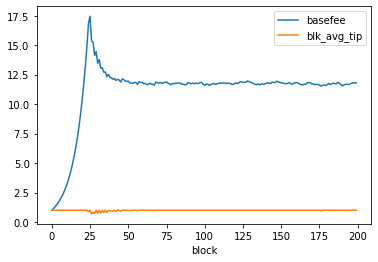

In [5]:
df.plot("block", ["basefee", "blk_avg_tip"])

Notice the increase at the beginning followed by a short drop? At the very beginning, the pool fills up quickly with many users hopeful to get their transactions in with a positive resulting payoff. The basefee increases until users start balking **and** the pool is exhausted. Once exhausted, basefee starts decreasing again to settle at the stationary point where the pool only includes transactions that are invalid given the stationary basefee.

We can see the pool length becoming stationary in the next plot, showing the length of the pool over time.

<AxesSubplot:xlabel='block'>

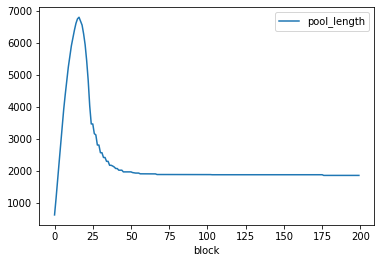

In [6]:
df.plot("block", "pool_length")

The remaining transactions are likely from early users who did not balk even though basefee was increasing, and who were quickly outbid by others.

## Demand shock

We look at a stationary setting, where the new demand coming in each new round follows a fixed expected rate of arrival. Demand shocks may be of two kinds:

- Same number of users, different values for transactions and costs for waiting.
- Increased number of users, same values and costs.

We'll consider the second scenario here, simply running the simulation again and increasing the $\lambda$ parameter of our Poisson arrival process suddenly, from expecting 2000, to expecting 6000 users per round.

In [7]:
demand_scenario = [2000 for i in range(100)] + [6000 for i in range(100)]
(df_jump, user_pool_jump, chain_jump) = simulate(demand_scenario, User1559)

0
100


The next plot shows the number of new users each round. We note at block 100 a sudden jump from around 2000 new users to 6000.

<AxesSubplot:xlabel='block'>

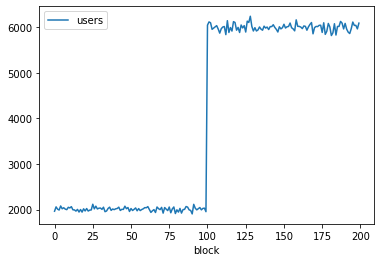

In [8]:
df_jump.plot("block", "users")

<AxesSubplot:xlabel='block'>

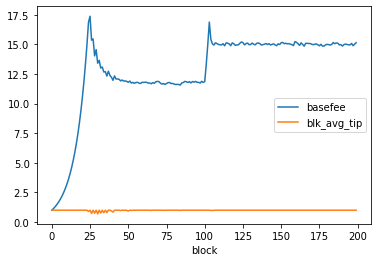

In [9]:
df_jump.plot("block", ["basefee", "blk_avg_tip"])

We see a jump around block 100, when the arrival rate of users switches from 2000 to 6000. The basefee increases in response. With a block limit of 20M gas, about 950 transactions fit into each block. Targeting half of this value, the basefee increases until more or less 475 transactions are included in each block.

Since our users' values and costs are always drawn from the same distribution, when 2000 users show up, we expect to let in about 25% of them (~ 475 / 2000), the 25% with greatest expected payoff. When 6000 users come in, we now only expect the "richest" 8% (~ 475 / 6000) to get in, so we "raise the bar" for the basefee, since we need to discriminate more.

<AxesSubplot:xlabel='block'>

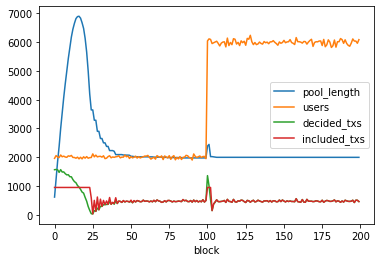

In [10]:
df_jump.plot("block", ["pool_length", "users", "decided_txs", "included_txs"])

As we see with the graph above, for a short while after block 100, blocks include more than the usual ~475 transactions. This is the transition between the old and the new stationary points.

Since we have a lot more new users each round, more of them are willing and able to pay for their transactions above the current basefee, and so get included. This keeps happening until the basefee reaches a new stationary level.

## Changing expected time

Up until now, users decided whether to join the transaction pool or not based on the expectation that they would be included at least 5 blocks after they join. They evaluated their payoff assuming that basefee did not change (due to stationarity) for these 5 blocks. If their value for transacting minus the cost of waiting for 5 blocks minus the cost of transacting is positive, they sent their transactions in!

$$ \texttt{payoff} = \texttt{value} - \texttt{cost from waiting 5 blocks} - \texttt{transaction fee} > 0 $$

Under a stationary demand however, users can expect to be included in the next block. So let's have user expect to be included in the next block, right after their appearance, and see what happens. We do this by subclassing our `User1559` agent and overriding its `expected_time` method.

In [11]:
class OptimisticUser(User1559):
    def expected_time(self, params):
        return 0
    
demand_scenario = [2000 for i in range(100)] + [6000 for i in range(100)]
(df_opti, user_pool_opti, chain_opti) = simulate(demand_scenario, OptimisticUser)

0
100


<AxesSubplot:xlabel='block'>

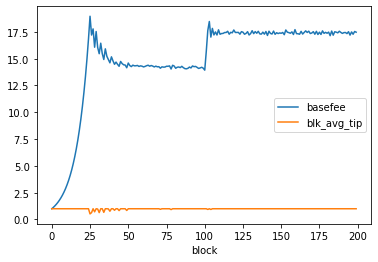

In [12]:
df_opti.plot("block", ["basefee", "blk_avg_tip"])

The plot looks the same as before. But let's look at the average basefee for the last 50 blocks in this scenario and the last.

In [13]:
df_opti[(df.block > 150)][["basefee"]].mean()

basefee    17.423325
dtype: float64

In [14]:
df_jump[(df.block > 150)][["basefee"]].mean()

basefee    15.008151
dtype: float64

When users expect to be included in the next block rather than wait for at least 5, the basefee increases! This makes sense if we come back to our payoff definition:

$$ \texttt{payoff} = \texttt{value} - \texttt{cost from waiting} - \texttt{transaction fee} $$

The estimated cost for waiting is lower now since users estimate they'll be included in the next block and not wait 5 blocks to get in. Previously, some users with high values but high time preferences might have been discouraged to join the pool. Now these users don't expect to wait as much, and since their values are high, they don't mind bidding for a higher basefee either. We can check indeed that on average, users included in this last scenario have higher values than users included in the previous one.

To do so, we export to pandas `DataFrame`s the user pool (to obtain their values and costs) and the chain (to obtain the addresses of included users in the last 50 blocks).

In [15]:
user_pool_opti_df = user_pool_opti.export().rename(columns={ "pub_key": "sender" })
chain_opti_df = chain_opti.export()

Let's open these up and have a look at the data. `user_pool_opti_df` registers all users we spawned in our simulation.

In [16]:
user_pool_opti_df.tail()

,user,sender,value,wakeup_block,user_type,cost_per_unit
799548,1559 affine user with value 12819348508 and co...,ba465d7974c5892d,12.819349,199,user_1559,0.700730
799549,1559 affine user with value 18537280466 and co...,f04b08f5ad895752,18.537280,199,user_1559,0.513428
799550,1559 affine user with value 19958064968 and co...,882c05a882fdedf9,19.958065,199,user_1559,0.875973
799551,1559 affine user with value 12384443528 and co...,bbf49a042be8275e,12.384444,199,user_1559,0.198828
799552,1559 affine user with value 7775594989 and cos...,199b0886d9794faf,7.775595,199,user_1559,0.560256


Meanwhile, `chain_opti_df` lists all the transactions included in the chain.

In [17]:
chain_opti_df.tail()

,block_height,tx_index,basefee,tx,start_block,sender,gas_used,tx_hash,gas_premium,max_fee,tip
107018,199,449,17.472434,1559 Transaction ed8fc8b61dd25f86: max_fee 190...,199,1f74eb018eeb88f1,21000,ed8fc8b61dd25f86,1.0,19.096948,1000000000
107019,199,450,17.472434,1559 Transaction 2c76279c942778d9: max_fee 196...,199,ebd094ab1d08d6b2,21000,2c76279c942778d9,1.0,19.658752,1000000000
107020,199,451,17.472434,1559 Transaction 8ca09542de679fa5: max_fee 187...,199,2b66fd32663e98b6,21000,8ca09542de679fa5,1.0,18.720150,1000000000
107021,199,452,17.472434,1559 Transaction 8cd8a1a2401c6617: max_fee 191...,199,48c54d56ad46667d,21000,8cd8a1a2401c6617,1.0,19.136768,1000000000
107022,199,453,17.472434,1559 Transaction 29f8d5245d7bc482: max_fee 194...,199,b1efab85f225def1,21000,29f8d5245d7bc482,1.0,19.480442,1000000000


With a simple join on the `sender` column we can associate each user with their included transaction. We look at the average value of included users after the second stationary point.

In [18]:
chain_opti_df[(chain_opti_df.block_height >= 150)].join(
    user_pool_opti_df.set_index("sender"), on="sender"
)[["value"]].mean()

value    19.199994
dtype: float64

When users expect to be included at least one block after they send their transaction, the average value of included users is around 19.2 Gwei.

In [19]:
user_pool_jump_df = user_pool_jump.export().rename(columns={ "pub_key": "sender" })
chain_jump_df = chain_jump.export()
chain_jump_df[(chain_jump_df.block_height >= 150)].join(
    user_pool_jump_df.set_index("sender"), on="sender"
)[["value"]].mean()

value    18.67274
dtype: float64

But when users expect to be included at least _five_ blocks after, the average value of included users is around 18.7 Gwei, confirming that when users expect next block inclusion, higher value users get in and raise the basefee in the process.

## Conclusion

We've looked at 1559 when users with their own values and costs decide whether to join the pool or not based on the current basefee level. These users estimate their ultimate payoff by assuming _stationarity_: the demand between rounds follows the same arrival process and the same distribution of values and costs. In this stationary environment, basefee settles on some value and mostly stays there, allowing users to estimate their payoff should they wait for five or one blocks to be included.

We've again left aside some important questions. Here all users simply leave a 1 Gwei premium in their transactions. In reality, we should expect users to attempt to "game" the system by leaving higher tips to get in first. We can suppose that in a stationary environment, "gaming" is only possible until basefee reaches its stationary point (during the transition period) and exhausts the feasible demand. We will leave this question for another notebook.

(Temporary) non-stationarity is more interesting. The [5% meme](https://insights.deribit.com/market-research/analysis-of-eip-2593-escalator/) during which sudden demand shocks precipitate a large influx of new, high-valued transactions should also see users try to outcompete each other based on premiums alone, until basefee catches up. The question of whether 1559 offers anything in this case or whether the whole situation would look like a first price auction may be better settled empirically, but we can intuit that 1559 would smooth the process slightly by [offering a (laggy) price oracle](https://twitter.com/onurhsolmaz/status/1286068365812011009).

And then we have the question of miner collusion, which rightfully agitates a lot of the ongoing conversation. In the simulations we do here, we instantiated one transaction pool only, which should tell you that we are looking at a "centralised", honest miner that includes transactions as much as possible, and not a collection or a cartel of miners cooperating. We can of course weaken this assumption and have several mining pools with their own behaviours and payoff evaluations, much like we modelled our users. We still would like to have a good theoretical understanding of the risks and applicability of miner collusion strategies. Onward!

---

#### (Bonus) Ex post individual rationality

_Individual rationality_ is the idea that agents won't join a mechanism unless they hope to make some positive payoff out of it. I'd rather not transact if my value for transacting minus my costs is negative.

In general, we like this property and we want to make the mechanism individually rational to as many agents as possible. Yet, some mechanisms fail to satisfy _ex post_ individual rationality: I might _expect_ to make a positive payoff from the mechanism, but some _realisation_ of the mechanism exists where my payoff is negative.

Take an auction. As long as my bid is lower or equal to my value for the auctioned item, the mechanism is ex post individually rational for me: I can never "overpay". If I value the item for 10 ETH and decide to bid 11 ETH, in a first-price auction where I pay for my bid if I have the highest, there is a realisation of the mechanism where I am the winner and I am asked to pay 11 ETH. My payoff is -1 ETH then.

In the transaction fee market, ex post individual rationality is not guaranteed unless I can cancel my transaction. In the simulations here, we do not offer this option to our agents. They expect to wait for inclusion for a certain amount of blocks, and evaluate whether their payoff after that wait is positive or not to decide whether to send their transaction or not. However, some agents might wait longer than their initial estimation, in particular before the mechanism reaches stationarity. Some realisations of the mechanism then yield a negative payoff for these agents, and the mechanism is not ex post individually rational.

Let's look at the agents' payoff using the transcript of transactions included in the chain. For each transaction, we want to find out what was the ultimate payoff for the agent who sent it in. If the transaction was included much later than the agent's initial estimation, this payoff is negative, and the mechanism wasn't ex post individually rational to them.

In [20]:
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })
chain_df = chain.export()
user_txs_df = chain_df.join(user_pool_df.set_index("sender"), on="sender")

In the next chunk we obtain the users' payoffs: their value minus the costs incurred from the transaction fee and the time they waited.

In [21]:
user_txs_df["payoff"] = user_txs_df.apply(
    lambda row: row.user.payoff({
        "current_block": row.block_height,
        "gas_price": row.tx.gas_price({
            "basefee": row.basefee * (10 ** 9) # we need basefee in wei
        })
    }) / (10 ** 9), # put payoff is in Gwei
    axis = 1
)
user_txs_df["epir"] = user_txs_df.payoff.apply(
    lambda payoff: payoff >= 0
)

Now we count the fraction of users in each block who received a positive payoff.

In [22]:
epir_df = pd.concat([
    user_txs_df[["block_height", "tx_hash"]].groupby(["block_height"]).agg(["count"]),
    user_txs_df[["block_height", "epir"]][user_txs_df.epir == True].groupby(["block_height"]).agg(["count"])
], axis = 1)
epir_df["percent_epir"] = epir_df.apply(
    lambda row: row.epir / row.tx_hash * 100,
    axis = 1
)

Let's plot it!

<AxesSubplot:xlabel='block_height'>

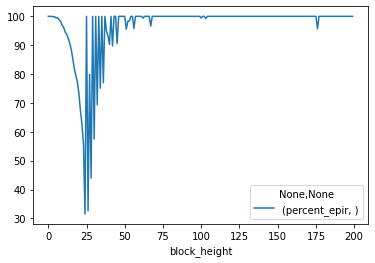

In [23]:
epir_df.reset_index().plot("block_height", ["percent_epir"])

At the very beginning, all users (100%) have positive payoff. They have only waited for 1 block to get included. This percentage steadily drops, as basefee increases: some high value users waiting in the pool get included much later than they expected, netting a negative payoff.

Once we pass the initial instability (while basefee is looking for its stationary value), all users receive a positive payoff. This is somewhat expected: once basefee has increased enough to weed out excess demand, users are pretty much guaranteed to be included in the next block, and so the realised waiting time will always be less than their estimate.

---

_Acknowledgements:_ [Sacha Saint-Leger](https://twitter.com/ssaintleger) for his comments, edits and corrections (all errors remain mine); [Dan Finlay](https://twitter.com/danfinlay) for prompting a live discussion of this notebook in a recent call (link TBD).

_Check out also:_ A recent [ethresear.ch post](https://ethresear.ch/t/a-mechanism-for-daily-autonomous-gas-price-stabilization/7762) by [Onur Solmaz](https://twitter.com/onurhsolmaz), on a 1559-inspired mechanism for daily gas price stabilization, with simulations.